In [1]:
import numpy as np
import oceanDAS as odas
import h5py
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone
from scipy import signal

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'

# for each site: 1 channel and 1 ground truth 
# Calculate waves from correction factor at each site
# Calculate differentials
# Bin differentials by wave period, height, direction, tidal stage
# things to save for each site: bins and differentials

In [2]:
pname = 'HomerAK_Williams/'
# load ground truth spectra:
with h5py.File(pname+'NDBC-46108_spectra.h5','r') as fp:
    sdate = fp['DATE'][:]/1e9 # POSIX time stamp (s) (convert from ns to s)
    sfreq = fp['FREQ'][:] # Hz
    sspec = fp['SPEC'][:] # m^2/Hz
nt = len(sdate)     # number of buoy spectra

# calculate wave stats from spectra for comparison:
hs_hombuoy = np.zeros(nt)
tp_hombuoy = np.zeros(nt)
te_hombuoy = np.zeros(nt)
for jj in range(nt):
    ds_psd_corr = sspec[jj,(sfreq > 0.04) & (sfreq < 0.35)]
    f_psd = sfreq[(sfreq > 0.04) & (sfreq < 0.35)]
    fe = ((ds_psd_corr * f_psd) / ds_psd_corr.sum() ).sum() #(f*E)/E
    te_hombuoy[jj] = 1/fe
    tp_hombuoy[jj] = 1/(f_psd[np.argmax(ds_psd_corr)])
    bandwidth = (f_psd[1::] - f_psd[0:-1]).mean()
    hs_hombuoy[jj] = 4*np.sqrt( ds_psd_corr.sum() * bandwidth ) 

# load ground truth time points 
with h5py.File(pname+'NDBC-46108_statistics.h5','r') as fp:
    ndate = fp['DATE'][:]/1e9 # POSIX time stamp (s) (convert from ns to s)
    WVHT = fp['WVHT'][:] # significant wave height (m)
    SwH = fp['SwH'][:] # swell height (m)
    SwP = fp['SwP'][:] # swell period (s)
    WWH = fp['WWH'][:] # wind wave height (m)
    WWP = fp['WWP'][:] # wind wave period (s)
    SwD = fp['SwD'][:] # swell direction (N, NNW, NW, WNW, ...)
    WWD = fp['WWD'][:] # wind wave direction 
    APD = fp['APD'][:] # average wave period (s)
    MWD = fp['MWD'][:] # mean wave direction (deg)

# cable axis 268 - 92
MWD[MWD>180] = np.abs(MWD[MWD>180] - 268)
MWD[MWD<=180] = np.abs(MWD[MWD<=180] - 92)


# load strain at all channels  then pull out channel 31
fname = 'GCI_TERRA_2p5Hz_data.h5'
onechn = False
rawstrain,das_time,chnl,depth,metadata = odas.loadHomer(pname,fname,onechn)
rawstrain = rawstrain[~np.isnan(das_time),31]
das_time = das_time[~np.isnan(das_time)]
depth = depth[31]
ns = len(rawstrain)

# Calculate strain spectra corresponding to each buoy spectra
nns = int(200*metadata['fs'])   # number of samples for each FFT (to match buoy resolution)
nsg = int(30*60*metadata['fs']) # number of samples in each window

# Calculate depth attenuation function to translate buoy surface to pressure at bed 
L,_ = odas.dispersion(depth,1 / sfreq)
attenuation = np.exp((1/L)*np.abs(depth)*(-1))**2 # square for energy
attenuation[attenuation>150]=np.nan
sspec = sspec*attenuation

# calculate correction factor for each point in time
ss = np.zeros((nt,len(sfreq)))
for it in range(nt):
    ii = np.argmin(abs(sdate[it]-das_time))
    i1 = np.maximum(0,ii-nsg//2)
    i2 = np.minimum(ns,ii+nsg//2)
    freq_e,temp = signal.welch(rawstrain[i1:i2],fs=metadata['fs'],nperseg=nns,detrend=False,scaling='density')
    temp = np.interp(sfreq, freq_e, temp)
    ss[it,:] = sspec[it,:]/temp
    
ss_med = np.nanmedian(ss,axis=0)

hs_hom = np.zeros(len(ndate))
tp_hom = np.zeros(len(ndate))
te_hom = np.zeros(len(ndate))
for it in range(len(ndate)):
    ii = np.argmin(abs(ndate[it]-das_time))
    i1 = np.maximum(0,ii-nsg//2)
    i2 = np.minimum(ns,ii+nsg//2)
    tp_hom[it], te_hom[it], hs_hom[it] = odas.DAS_wave_conversion(
        rawstrain[i1:i2],metadata['fs'],depth,ss_med,sfreq)

# plt.figure()
# plt.plot(ndate,tp_hom,'r')
# plt.plot(ndate,APD,'k:')
# plt.plot(ndate,WWP,'k--')
# plt.plot(sdate,tp_hombuoy,'b')

# plt.figure()
# plt.plot(ndate,hs_hom,'r')
# plt.plot(ndate,WVHT,'k')
# plt.plot(sdate,hs_hombuoy,'b')

tvec_hom = ndate
hs_hom_dif = WVHT - hs_hom
tp_hom_dif = APD - tp_hom
te_hom_dif = APD - te_hom


# calculate r2 and mse
mask = np.isfinite(te_hom) & np.isfinite(APD)
corr = np.corrcoef(te_hom[mask], APD[mask])
corr_hom_te = corr[0,1]**2
rmse_hom_te = np.sqrt(np.mean((te_hom[mask]-APD[mask])**2))
mask = np.isfinite(hs_hom) & np.isfinite(WVHT)
corr = np.corrcoef(hs_hom[mask], WVHT[mask])
corr_hom_hs = corr[0,1]**2
rmse_hom_hs = np.sqrt(np.mean((hs_hom[mask]-WVHT[mask])**2))
print(len(mask))
print(rmse_hom_hs,corr_hom_hs)
print(rmse_hom_te,corr_hom_te)
print(min(WVHT),max(WVHT))
print(min(APD),max(APD))

del sspec, ss_med, sfreq, L,rawstrain,das_time

/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_das/oceanDAS.py:300: RuntimeWarning: divide by zero encountered in true_divide
  L,_ = dispersion(depth,1/f_psd)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_das/oceanDAS.py:269: RuntimeWarning: divide by zero encountered in power
  k = omega ** 2 / g * (1 - np.exp(-(omega * np.sqrt(h / g)) ** (5/2))) ** (-2/5)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_das/oceanDAS.py:269: RuntimeWarning: invalid value encountered in multiply
  k = omega ** 2 / g * (1 - np.exp(-(omega * np.sqrt(h / g)) ** (5/2))) ** (-2/5)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_das/oceanDAS.py:308: RuntimeWarning: divide by zero encountered in power
  ds_psd_corr[np.isnan(ds_psd_corr)] = (min_psd)*np.power(f_noise[0],4)*np.power(f_noise,-4)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_das/oceanDAS.p

1287
0.2879057237066401 0.5563363434918313
1.5942016732841797 0.1317332603818339
0.1 1.2
2.0 6.7


In [6]:
# plot example of Duck correction factor
pname = 'DuckNC_Glover/'

with np.load(pname+'cald_comparison_11m.npz') as data:
    duc_hs_das = data['hs_d']
    duc_tp_das = data['tp_d']
    duc_te_das = data['te_d']
    duc_hs_pre = data['hs_p']
    duc_tp_pre = data['tp_p']
    duc_te_pre = data['te_p']
    duc_meanDir = data['md']

duc_tp_das[duc_tp_das<2] = np.nan
hs_duck_dif = duc_hs_pre - duc_hs_das
tp_duck_dif = duc_tp_pre - duc_tp_das

print(min(duc_hs_pre),max(duc_hs_pre))
print(min(duc_te_pre),max(duc_te_pre))
print(len(hs_duck_dif))

0.20884011864897714 1.3361257033950018
5.671011929601122 13.030564502894011
252


In [5]:
# plot calculated wave chars for Oliktok
pname = 'OliktokPoint_Smith/'

d = nc.Dataset(pname+'CODAS_2022-08_DASwaveoutputs_v230612.nc')
time_oli = d['time'][:]
hs_oli = d['Hs'][400,:]
tp_oli = d['Tp'][400,:]
te_oli = d['Te'][400,:]

d = nc.Dataset(pname+'SWIFT18_OliktokPt_Aug2022_reprocessedIMU_1Hzspectra_convertedTe.nc')
time_swift = d['time'][:]
hs_swift = d['sigwaveheight_new'][:]
tp_swift = d['peakwaveperiod'][:]
te_swift = d['energywaveperiod'][:]
dir_swift = d['peakwavedirT'][:]

# plt.figure()
# plt.plot(time_swift,hs_swift,'k')
# plt.plot(time_oli,hs_oli,'r')

hs_swift = np.interp(time_oli,time_swift,hs_swift)
tp_swift = np.interp(time_oli,time_swift,tp_swift)
te_swift = np.interp(time_oli,time_swift,te_swift)
dir_swift = np.interp(time_oli,time_swift,dir_swift)


hs_oli_dif = hs_swift - hs_oli
tp_oli_dif = tp_swift - tp_oli
te_oli_dif = te_swift - te_oli

# cable axis 268 - 92
idx = (dir_swift>90) & (dir_swift<270)
idx2 = dir_swift>270
dir_swift[idx] = np.abs(180 - dir_swift[idx])
dir_swift[idx2] = np.abs(360 - dir_swift[idx2])


# calculate r2 and mse
mask = np.isfinite(tp_oli) & np.isfinite(tp_swift)
corr = np.corrcoef(tp_oli[mask], tp_swift[mask])
corr_oli_te = corr[0,1]**2
rmse_oli_te = np.sqrt(np.mean((tp_oli[mask]-tp_swift[mask])**2))
mask = np.isfinite(hs_oli) & np.isfinite(hs_swift)
corr = np.corrcoef(hs_oli[mask], hs_swift[mask])
corr_oli_hs = corr[0,1]**2
rmse_oli_hs = np.sqrt(np.mean((hs_oli[mask]-hs_swift[mask])**2))
print(len(mask))
print(rmse_oli_hs,corr_oli_hs)
print(rmse_oli_te,corr_oli_te)


print(min(hs_oli),max(hs_oli))
print(min(tp_swift),max(tp_swift))

98
0.13926448496701704 0.1133320296601129
1.1777361618060855 0.01818642113940203
0.02058006000971958 0.7894013688885994
0.3796117306897896 5.764479279897663


In [7]:
# plot calculated wave chars for MV
pname = 'MarthasVineyard_Smith/'
d = nc.Dataset(pname+'mvco_2022-12_waveoutputs_nch2112.nc')
time_mv = d['time'][:]# calculated every 30 minutes
chn = d['channels'][:]
hs_mv = d['Hs'][chn==1696,:].flatten()
tp_mv = d['Tp'][chn==1696,:].flatten()
te_mv = d['Te'][chn==1696,:].flatten()

d = nc.Dataset(pname+'asit_lidar_mininode_waveoutputs2022344_2022363.nc')
idx = int(np.max(time_mv)/20)# calculated every 20 minutes
time_lidar = d['time'][-idx:] - d['time'][-idx]
hs_lidar = d['Hs'][-idx:]
tp_lidar = d['Tp'][-idx:]
te_lidar = d['Te'][-idx:]

# plt.figure()
# plt.plot(time_lidar,hs_lidar,'k')
# plt.plot(time_mv,hs_mv,'r')

hs_lidar = np.interp(time_mv,time_lidar,hs_lidar)
tp_lidar = np.interp(time_mv,time_lidar,tp_lidar)
te_lidar = np.interp(time_mv,time_lidar,te_lidar)

hs_mv_dif = hs_lidar - hs_mv
tp_mv_dif = tp_lidar - tp_mv
te_mv_dif = te_lidar - te_mv


# calculate r2 and mse
mask = np.isfinite(te_mv) & np.isfinite(te_lidar)
corr = np.corrcoef(te_mv[mask], te_lidar[mask])
corr_mv_te = corr[0,1]**2
rmse_mv_te = np.sqrt(np.mean((te_mv[mask]-te_lidar[mask])**2))
mask = np.isfinite(hs_mv) & np.isfinite(hs_lidar)
corr = np.corrcoef(hs_mv[mask], hs_lidar[mask])
corr_mv_hs = corr[0,1]**2
rmse_mv_hs = np.sqrt(np.mean((hs_mv[mask]-hs_lidar[mask])**2))
print(len(mask))
print(rmse_mv_hs,corr_mv_hs)
print(rmse_mv_te,corr_mv_te)

print(min(hs_lidar),max(hs_lidar))
print(min(te_lidar),max(te_lidar))

385
0.5896177306463646 0.7881665480021658
0.6300669218987689 0.8267188701399911
0.3497412282285841 5.253775439452807
4.333466928130113 10.928229650072675


In [8]:
# # plot example of KNO wave stats
pname = 'KNO_Glover/'


with np.load(pname+'waveCalcs_F1_ch124_p3.npz') as data:
    te_das = data['te_das']
    tp_das = data['tp_das']
    hs_das = data['hs_das']
    te_pre = data['te_pre']
    tp_pre = data['tp_pre']
    hs_pre = data['hs_pre']

print(len(te_das))
print(min(hs_pre),max(hs_pre))
print(min(te_pre),max(te_pre))

618
0.23836326048092543 0.8497590540985721
7.012460473838291 14.392206972981095


In [9]:
# plot example of Florence wave stats
pname = 'FlorenceOR_Ifju/'


with np.load(pname+'empCal_Ch700_Flo.npz') as data:
    te_das_flo = data['te_das']
    hs_das_flo = data['hs_das']
    te_pre_flo = data['te_pre']
    hs_pre_flo = data['hs_pre']

print(len(te_das_flo))
print(min(hs_pre_flo),max(hs_pre_flo))
print(min(te_pre_flo),max(te_pre_flo))

144
0.13870660799670081 1.5228613812168683
7.375243552970476 13.790795620833721


Text(0, 2.4, 'D)')

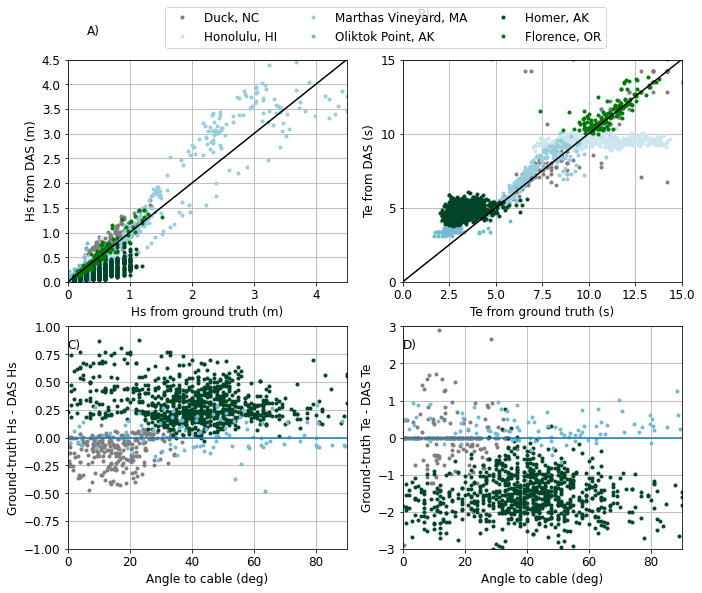

In [11]:
x, clrs, h_flo, h_hom, h_oli, h_mv, h_kno, h_duck = odas.all_line_colors()
plt.rc('font', size=12) 

fig,ax = plt.subplots(2,2,figsize=(11,9))
ax= ax.ravel()
ax[0].plot(duc_hs_pre,duc_hs_das,c = 'tab:gray',marker='.',ls='None')
ax[0].plot(hs_pre,hs_das,c = clrs[x==h_kno,:],marker='.',ls='None')
ax[0].plot(hs_lidar,hs_mv,c = clrs[x==h_mv,:],marker='.',ls='None')
ax[0].plot(hs_swift,hs_oli,c = clrs[x==h_oli,:],marker='.',ls='None')
ax[0].plot(WVHT,hs_hom,c = clrs[x==h_hom,:],marker='.',ls='None')
ax[0].plot(hs_pre_flo,hs_das_flo,c = clrs[x==h_flo,:],marker='.',ls='None')
ax[0].plot((0,6),(0,6),'k')
ax[0].set_xlabel('Hs from ground truth (m)')
ax[0].set_ylabel('Hs from DAS (m)')
ax[0].set_xlim([0,4.5])
ax[0].set_ylim([0,4.5])
ax[0].grid(which='major', axis='both')

ax[1].plot(duc_tp_pre,duc_tp_das,c = 'tab:gray',label='Duck, NC',marker='.',ls='None')
ax[1].plot(te_pre,te_das,c = clrs[x==h_kno,:],label='Honolulu, HI',marker='.',ls='None')
ax[1].plot(te_lidar,te_mv,c = clrs[x==h_mv,:],label='Martha''s Vineyard, MA',marker='.',ls='None')
ax[1].plot(tp_swift,tp_oli,c = clrs[x==h_oli,:],label='Oliktok Point, AK',marker='.',ls='None')
ax[1].plot(APD,te_hom,c = clrs[x==h_hom,:],label='Homer, AK',marker='.',ls='None')
ax[1].plot(te_pre_flo,te_das_flo,c = clrs[x==h_flo,:],label='Florence, OR',marker='.',ls='None')
ax[1].set_xlabel('Te from ground truth (s)')
ax[1].set_ylabel('Te from DAS (s)')
ax[1].plot((0,15),(0,15),'k')
ax[1].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax[1].set_xlim([0,15])
ax[1].set_ylim([0,15])
ax[1].legend(loc=(-0.85,1.05),ncol=3)
ax[1].grid(which='major', axis='both')

ax[2].plot(duc_meanDir,hs_duck_dif,c = 'tab:gray',label='Duck, NC',marker='.',ls='None')
ax[2].plot(MWD,hs_hom_dif,c = clrs[x==h_hom,:],label='Homer, AK',marker='.',ls='None')
ax[2].plot(dir_swift,hs_oli_dif,c = clrs[x==h_oli,:],label='Oliktok, AK',marker='.',ls='None')
ax[2].set_xlabel('Angle to cable (deg)')
ax[2].set_ylabel('Ground-truth Hs - DAS Hs')
ax[2].axhline(y=0)
ax[2].set_ylim([-1,1])
ax[2].set_xlim([0,90])
ax[2].grid(which='major', axis='both')

ax[3].plot(duc_meanDir,tp_duck_dif,c = 'tab:gray',marker='.',ls='None')
ax[3].plot(MWD,te_hom_dif,c = clrs[x==h_hom,:],marker='.',ls='None')
ax[3].plot(dir_swift,te_oli_dif,c = clrs[x==h_oli,:],marker='.',ls='None')
ax[3].set_xlabel('Angle to cable (deg)')
ax[3].set_ylabel('Ground-truth Te - DAS Te')
ax[3].axhline(y=0)
ax[3].set_ylim([-3,3])
ax[3].set_xlim([0,90])
ax[3].grid(which='major', axis='both')

ax[0].text(0.3,5, 'A)')
ax[1].text(0.8,17.8, 'B)')
ax[2].text(0,0.8, 'C)')
ax[3].text(0,2.4, 'D)')

# plt.savefig('figs/ScatterHT_all.png')

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(10,10))
# ax= ax.ravel()
# ax[0].scatter(MWD,hs_hom_dif,c = clrs[x==h_hom,:],label='Homer, AK')
# ax[0].scatter(dir_swift,hs_oli_dif,c = clrs[x==h_oli,:],label='Oliktok, AK')
# ax[0].scatter(awac11[:,8],hs_duck_dif,c = 'tab:gray',label='Duck, NC')
# ax[0].set_xlabel('Wave Dir (deg)')
# ax[0].set_ylabel('Ground-truth Hs - DAS Hs')
# ax[0].legend()
# ax[0].axhline(y=0)
# ax[0].set_ylim([-1,1])

# # ax[1].scatter(hs_lidar,te_mv_dif,c='k',label='MV')
# ax[1].scatter(MWD,te_hom_dif,c = clrs[x==h_hom,:])
# ax[1].scatter(dir_swift,te_oli_dif,c = clrs[x==h_oli,:])
# ax[1].scatter(awac11[:,8],tp_duck_dif,c = 'tab:gray')
# ax[1].set_xlabel('Wave Dir (deg)')
# ax[1].set_ylabel('Ground-truth Te - DAS Te')
# ax[1].axhline(y=0)
# ax[1].set_ylim([-3,3])

# plt.savefig('ScatterHTDir_all.png')